# Modelling with PyHealth (using NOTEEVENTS_ICD)

## Libraries

In [1]:
import pandas as pd
import numpy as np

In [ ]:
%pip install torch==2.1.0

In [1]:
import torch
print(torch.__version__)

# Install required packages.
import os
os.environ['TORCH'] = torch.__version__

2.1.0+cpu


In [13]:
%pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
%pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html

Looking in links: https://data.pyg.org/whl/torch-${TORCH}.html
Note: you may need to restart the kernel to use updated packages.
Looking in links: https://data.pyg.org/whl/torch-${TORCH}.html
Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install torch-geometric

In [2]:
# carica i dati dai file csv
noteevents = pd.read_csv('data/NOTEEVENTS_ICD.csv')
patients = pd.read_csv('data/PATIENTS.csv')

# seleziona i pazienti presenti in NOTEEVENTS_ICD
selected_patients = patients[patients['SUBJECT_ID'].isin(noteevents['SUBJECT_ID'].unique())]

# salva il risultato in un file csv
selected_patients.to_csv('data/PATIENTS_SEL.csv', index=False)


## Loading MIMIC-III into PyHealth

In [1]:
from pyhealth.datasets import MIMIC3Dataset

dataset = MIMIC3Dataset(
    root='data/',
    tables=["DIAGNOSES_ICD","PROCEDURES_ICD","PRESCRIPTIONS","NOTEEVENTS_ICD"],
    code_mapping={"NDC": ("ATC", {"target_kwargs": {"level": 4}})},
    # refresh_cache=True,
    # dev=True
)

In [2]:
dataset.stat()


Statistics of base dataset (dev=False):
	- Dataset: MIMIC3Dataset
	- Number of patients: 1560
	- Number of visits: 5014
	- Number of visits per patient: 3.2141
	- Number of events per visit in DIAGNOSES_ICD: 11.5987
	- Number of events per visit in PROCEDURES_ICD: 3.8771
	- Number of events per visit in PRESCRIPTIONS: 44.3879
	- Number of events per visit in NOTEEVENTS_ICD: 11.0782



'\nStatistics of base dataset (dev=False):\n\t- Dataset: MIMIC3Dataset\n\t- Number of patients: 1560\n\t- Number of visits: 5014\n\t- Number of visits per patient: 3.2141\n\t- Number of events per visit in DIAGNOSES_ICD: 11.5987\n\t- Number of events per visit in PROCEDURES_ICD: 3.8771\n\t- Number of events per visit in PRESCRIPTIONS: 44.3879\n\t- Number of events per visit in NOTEEVENTS_ICD: 11.0782\n'

## Reading retrieved dataset

In [3]:
# get patient dictionary
patient_dict = dataset.patients
print(list(patient_dict.keys()))
print(len(patient_dict))

['10055', '10071', '10077', '10144', '10160', '10174', '10197', '10207', '10254', '10285', '1029', '10302', '10304', '10310', '10328', '10342', '10369', '10414', '10434', '10442', '10478', '10487', '10488', '1050', '10594', '10612', '10618', '10634', '10635', '10637', '10660', '10679', '10687', '1069', '10742', '10774', '10820', '10832', '10859', '10884', '109', '10906', '10932', '10939', '10973', '10976', '10977', '11043', '11102', '11108', '11135', '11165', '11171', '112', '11205', '1122', '11234', '11236', '11242', '11255', '11318', '11342', '11346', '11421', '11442', '11464', '11479', '11588', '11590', '11604', '11623', '11634', '11716', '11763', '11764', '11778', '11818', '11825', '11830', '11838', '11861', '1187', '11876', '11885', '11892', '11897', '11932', '1197', '11970', '12039', '12076', '12110', '12113', '12125', '12149', '12198', '12203', '12217', '1223', '12281', '12344', '124', '12411', '12446', '12467', '12501', '12515', '12521', '12566', '12567', '12690', '12706', '127

In [4]:
# get the "10" patient
patient = patient_dict["4096"]
patient.gender, patient.birth_datetime, patient.ethnicity, patient.death_datetime, patient.visits
print(patient.visits)

OrderedDict([('124383', Visit 124383 from patient 4096 with 86 events from tables ['DIAGNOSES_ICD', 'PROCEDURES_ICD', 'PRESCRIPTIONS', 'NOTEEVENTS_ICD']), ('161677', Visit 161677 from patient 4096 with 109 events from tables ['DIAGNOSES_ICD', 'PROCEDURES_ICD', 'PRESCRIPTIONS', 'NOTEEVENTS_ICD'])])


In [5]:
# get the visit list of this patient
visit_dict = patient.visits
print (list(visit_dict.keys()))

['124383', '161677']


In [6]:
# get the first visit
visit = visit_dict['124383']
visit.encounter_time, visit.available_tables, visit.num_events, visit.event_list_dict

(datetime.datetime(2170, 7, 20, 18, 9),
 ['DIAGNOSES_ICD', 'PROCEDURES_ICD', 'PRESCRIPTIONS', 'NOTEEVENTS_ICD'],
 86,
 {'DIAGNOSES_ICD': [Event with ICD9CM code 0389 from table DIAGNOSES_ICD,
   Event with ICD9CM code 5849 from table DIAGNOSES_ICD,
   Event with ICD9CM code 496 from table DIAGNOSES_ICD,
   Event with ICD9CM code 4280 from table DIAGNOSES_ICD,
   Event with ICD9CM code 42731 from table DIAGNOSES_ICD,
   Event with ICD9CM code 566 from table DIAGNOSES_ICD,
   Event with ICD9CM code 99592 from table DIAGNOSES_ICD,
   Event with ICD9CM code 4589 from table DIAGNOSES_ICD,
   Event with ICD9CM code 25080 from table DIAGNOSES_ICD,
   Event with ICD9CM code 4019 from table DIAGNOSES_ICD,
   Event with ICD9CM code 2859 from table DIAGNOSES_ICD,
   Event with ICD9CM code 78009 from table DIAGNOSES_ICD,
   Event with ICD9CM code 4439 from table DIAGNOSES_ICD,
   Event with ICD9CM code 5939 from table DIAGNOSES_ICD,
   Event with ICD9CM code 71590 from table DIAGNOSES_ICD,
   Even

In [7]:
visit.get_code_list(table='NOTEEVENTS_ICD')

['V419',
 '4019',
 '4439',
 '43491',
 '78060',
 '51189',
 '7840',
 '78650',
 '78609',
 '78605',
 '78096',
 '2724',
 '53081',
 '71590',
 '5770',
 '496',
 '27800',
 '7823',
 '42761',
 '2512',
 '5849',
 '78791',
 '3301']

## Modelling data for task of Drug Recommendation

In [8]:
from pyhealth.tasks import drug_recommendation_mimic3_fn
from pyhealth.datasets import split_by_patient, get_dataloader

mimic3sample = dataset.set_task(task_fn=drug_recommendation_mimic3_fn) # use default task
train_ds, val_ds, test_ds = split_by_patient(mimic3sample, [0.8, 0.1, 0.1])

Generating samples for drug_recommendation_mimic3_fn: 100%|██████████| 1560/1560 [00:00<00:00, 14176.30it/s]


In [9]:
mimic3sample.stat()

Statistics of sample dataset:
	- Dataset: MIMIC3Dataset
	- Task: drug_recommendation_mimic3_fn
	- Number of samples: 2012
	- Number of patients: 906
	- Number of visits: 2012
	- Number of visits per patient: 2.2208
	- conditions:
		- Number of conditions per sample: 18.8827
		- Number of unique conditions: 2099
		- Distribution of conditions (Top-10): [('4019', 1225), ('4280', 1021), ('42731', 783), ('41401', 767), ('5849', 594), ('25000', 537), ('53081', 458), ('5990', 393), ('40391', 389), ('2724', 386)]
	- procedures:
		- Number of procedures per sample: 7.0055
		- Number of unique procedures: 731
		- Distribution of procedures (Top-10): [('3893', 1047), ('9904', 776), ('9604', 529), ('3995', 505), ('966', 484), ('9671', 477), ('3891', 295), ('9672', 292), ('3961', 267), ('9915', 257)]
	- drugs:
		- Number of drugs per sample: 30.2271
		- Number of unique drugs: 406
		- Distribution of drugs (Top-10): [('B05XA', 1792), ('B01AB', 1561), ('A02BC', 1494), ('N02BE', 1465), ('V06DC', 138

"Statistics of sample dataset:\n\t- Dataset: MIMIC3Dataset\n\t- Task: drug_recommendation_mimic3_fn\n\t- Number of samples: 2012\n\t- Number of patients: 906\n\t- Number of visits: 2012\n\t- Number of visits per patient: 2.2208\n\t- conditions:\n\t\t- Number of conditions per sample: 18.8827\n\t\t- Number of unique conditions: 2099\n\t\t- Distribution of conditions (Top-10): [('4019', 1225), ('4280', 1021), ('42731', 783), ('41401', 767), ('5849', 594), ('25000', 537), ('53081', 458), ('5990', 393), ('40391', 389), ('2724', 386)]\n\t- procedures:\n\t\t- Number of procedures per sample: 7.0055\n\t\t- Number of unique procedures: 731\n\t\t- Distribution of procedures (Top-10): [('3893', 1047), ('9904', 776), ('9604', 529), ('3995', 505), ('966', 484), ('9671', 477), ('3891', 295), ('9672', 292), ('3961', 267), ('9915', 257)]\n\t- drugs:\n\t\t- Number of drugs per sample: 30.2271\n\t\t- Number of unique drugs: 406\n\t\t- Distribution of drugs (Top-10): [('B05XA', 1792), ('B01AB', 1561), (

In [10]:
# create dataloaders (torch.data.DataLoader)
train_loader = get_dataloader(train_ds, batch_size=32, shuffle=True)
val_loader = get_dataloader(val_ds, batch_size=32, shuffle=False)
test_loader = get_dataloader(test_ds, batch_size=32, shuffle=False)

In [11]:
len(train_ds), len(val_ds), len(test_ds)

(1593, 215, 204)

## Our Model

In [12]:
%load_ext autoreload
%autoreload 2

import importlib
import pyhealth.models

importlib.reload(pyhealth.models)

<module 'pyhealth.models' from 'C:\\Users\\AR\\Desktop\\Tirocinio_Tesi\\src\\pyhealth\\pyhealth\\models\\__init__.py'>

In [13]:
from pyhealth.models import GNN

model = GNN(
    dataset=mimic3sample,
    feature_keys=["procedures", "symptoms", "conditions"],
    label_key="drugs",
    k=0
)

c:\Users\AR\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
c:\Users\AR\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
c:\Users\AR\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
c:\Users\AR\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,


GNN(
  (x_dict): X_Dict(
    (pat_emb): Embedding(906, 128)
    (vis_emb): Embedding(2012, 128)
    (symp_emb): Embedding(714, 128)
    (proc_emb): Embedding(731, 128)
    (dis_emb): Embedding(2099, 128)
    (drug_emb): Embedding(406, 128)
  )
  (layer): GNNLayer(
    (gnn): GraphModule(
      (conv1): ModuleDict(
        (patient__has__visit): SAGEConv((-1, -1), 128, aggr=mean)
        (visit__presents__symptom): SAGEConv((-1, -1), 128, aggr=mean)
        (visit__has__disease): SAGEConv((-1, -1), 128, aggr=mean)
        (visit__has_treat__procedure): SAGEConv((-1, -1), 128, aggr=mean)
        (visit__has_received__drug): SAGEConv((-1, -1), 128, aggr=mean)
        (visit__rev_has__patient): SAGEConv((-1, -1), 128, aggr=mean)
        (symptom__rev_presents__visit): SAGEConv((-1, -1), 128, aggr=mean)
        (disease__rev_has__visit): SAGEConv((-1, -1), 128, aggr=mean)
        (procedure__rev_has_treat__visit): SAGEConv((-1, -1), 128, aggr=mean)
        (drug__rev_has_received__visit): S

Epoch 0 / 15:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-0, step-50 ---
loss: 0.1392


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 15.27it/s]

--- Eval epoch-0, step-50 ---
pr_auc_samples: 0.5303
loss: 0.1314
New best pr_auc_samples score (0.5303) at epoch-0, step-50



Epoch 1 / 15:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-1, step-100 ---
loss: 0.1238


Evaluation: 100%|██████████| 7/7 [00:01<00:00,  6.61it/s]

--- Eval epoch-1, step-100 ---
pr_auc_samples: 0.5404
loss: 0.1225
New best pr_auc_samples score (0.5404) at epoch-1, step-100



Epoch 2 / 15:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-2, step-150 ---
loss: 0.1200


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 14.90it/s]

--- Eval epoch-2, step-150 ---
pr_auc_samples: 0.5423
loss: 0.1206
New best pr_auc_samples score (0.5423) at epoch-2, step-150



Epoch 3 / 15:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-3, step-200 ---
loss: 0.1183


Evaluation: 100%|██████████| 7/7 [00:01<00:00,  6.78it/s]

--- Eval epoch-3, step-200 ---
pr_auc_samples: 0.5434
loss: 0.1212
New best pr_auc_samples score (0.5434) at epoch-3, step-200



Epoch 4 / 15:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-4, step-250 ---
loss: 0.1170


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 15.43it/s]

--- Eval epoch-4, step-250 ---
pr_auc_samples: 0.5440
loss: 0.1192
New best pr_auc_samples score (0.5440) at epoch-4, step-250



Epoch 5 / 15:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-5, step-300 ---
loss: 0.1158


Evaluation: 100%|██████████| 7/7 [00:01<00:00,  6.87it/s]

--- Eval epoch-5, step-300 ---
pr_auc_samples: 0.5464
loss: 0.1208
New best pr_auc_samples score (0.5464) at epoch-5, step-300



Epoch 6 / 15:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-6, step-350 ---
loss: 0.1143


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 15.27it/s]

--- Eval epoch-6, step-350 ---
pr_auc_samples: 0.5484
loss: 0.1175
New best pr_auc_samples score (0.5484) at epoch-6, step-350



Epoch 7 / 15:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-7, step-400 ---
loss: 0.1106


Evaluation: 100%|██████████| 7/7 [00:01<00:00,  6.96it/s]

--- Eval epoch-7, step-400 ---
pr_auc_samples: 0.5576
loss: 0.1140
New best pr_auc_samples score (0.5576) at epoch-7, step-400



Epoch 8 / 15:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-8, step-450 ---
loss: 0.1069


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 14.93it/s]

--- Eval epoch-8, step-450 ---
pr_auc_samples: 0.5658
loss: 0.1123
New best pr_auc_samples score (0.5658) at epoch-8, step-450



Epoch 9 / 15:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-9, step-500 ---
loss: 0.1026


Evaluation: 100%|██████████| 7/7 [00:01<00:00,  6.87it/s]

--- Eval epoch-9, step-500 ---
pr_auc_samples: 0.5730
loss: 0.1093
New best pr_auc_samples score (0.5730) at epoch-9, step-500



Epoch 10 / 15:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-10, step-550 ---
loss: 0.1001


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 14.61it/s]

--- Eval epoch-10, step-550 ---
pr_auc_samples: 0.5816
loss: 0.1064
New best pr_auc_samples score (0.5816) at epoch-10, step-550



Epoch 11 / 15:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-11, step-600 ---
loss: 0.0973


Evaluation: 100%|██████████| 7/7 [00:01<00:00,  6.93it/s]

--- Eval epoch-11, step-600 ---
pr_auc_samples: 0.5941
loss: 0.1042
New best pr_auc_samples score (0.5941) at epoch-11, step-600



Epoch 12 / 15:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-12, step-650 ---
loss: 0.0939


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 15.36it/s]

--- Eval epoch-12, step-650 ---
pr_auc_samples: 0.6064
loss: 0.1017
New best pr_auc_samples score (0.6064) at epoch-12, step-650



Epoch 13 / 15:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-13, step-700 ---
loss: 0.0909


Evaluation: 100%|██████████| 7/7 [00:01<00:00,  6.86it/s]

--- Eval epoch-13, step-700 ---
pr_auc_samples: 0.6195
loss: 0.1002
New best pr_auc_samples score (0.6195) at epoch-13, step-700



Epoch 14 / 15:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-14, step-750 ---
loss: 0.0885


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 15.60it/s]

--- Eval epoch-14, step-750 ---
pr_auc_samples: 0.6267
loss: 0.0965
New best pr_auc_samples score (0.6267) at epoch-14, step-750
Loaded best model


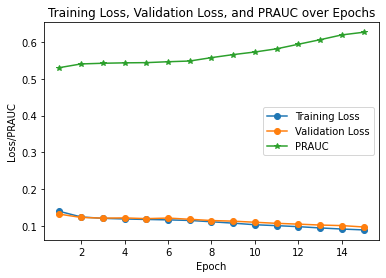

In [55]:
from pyhealth.trainer import Trainer

trainer = Trainer(model=model)
trainer.train(
    model_name="gnn",
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    epochs=15,
    optimizer_params = {"lr": 2 * 1e-4},
    monitor="pr_auc_samples",
    monitor_criterion="max",
)

### Results

loss: 0.0714
New best pr_auc_samples score (0.7785) at epoch-49, step-2550

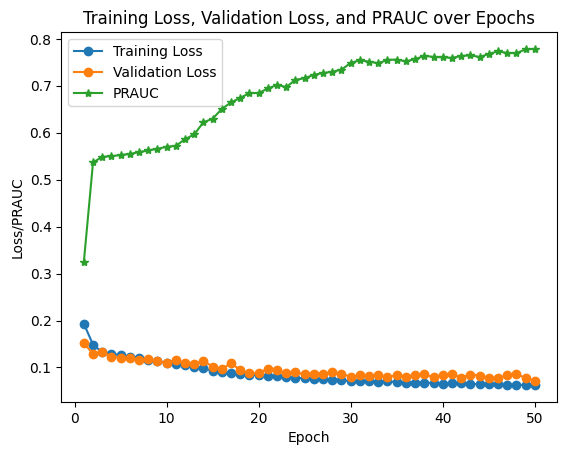

### Inference

In [56]:
from pyhealth.metrics import multilabel_metrics_fn

y_true, y_prob, loss = trainer.inference(test_loader)
print(loss)

Evaluation: 100%|██████████| 7/7 [00:00<00:00, 15.80it/s]

0.09048024458544594


In [57]:
print(y_true.shape)

print(y_true[y_true == 0].shape)
print(y_true[y_true == 1].shape)

(204, 406)
(76937,)
(5887,)


In [58]:
print(y_prob.shape)
print(y_prob.max())
print(y_prob.min())

(204, 406)
0.9909979
1.751393e-07


In [59]:
print(y_true)
print("------------------")
threshold = 0.5
y_prob_threshold = (y_prob >= threshold).astype(float)
print(y_prob_threshold)
print(y_prob_threshold[y_prob_threshold == 0].shape)
print(y_prob_threshold[y_prob_threshold == 1].shape)

[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
------------------
[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(77657,)
(5167,)


In [60]:
# risultati
metrics = ["accuracy", "f1_samples", "pr_auc_samples", "jaccard_samples", "precision_samples", "recall_samples"]
multilabel_metrics_fn(y_true, y_prob, metrics=metrics, threshold=0.5)

{'accuracy': 0.9449676422293055,
 'f1_samples': 0.5384796518487853,
 'pr_auc_samples': 0.658854414910753,
 'jaccard_samples': 0.3849090030842294,
 'precision_samples': 0.6389771833011251,
 'recall_samples': 0.5285011891456811}

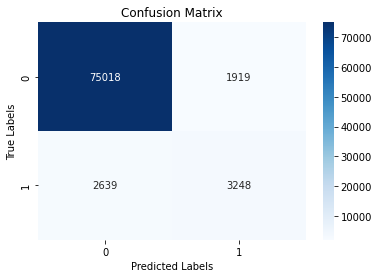

In [61]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(y_true.flatten(), y_prob_threshold.flatten())

sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt=".0f")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

### Interpret with HeteroExplainer

In [108]:
%load_ext autoreload
%autoreload 2

import importlib
import pyhealth.explainer

importlib.reload(pyhealth.explainer)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<module 'pyhealth.explainer' from 'C:\\Users\\AR\\Desktop\\Tirocinio_Tesi\\src\\pyhealth\\pyhealth\\explainer.py'>

In [114]:
from pyhealth.explainer import HeteroGraphExplainer

explainer = HeteroGraphExplainer(
    algorithm="GNNExplainer",
    dataset=test_loader.dataset,
    model=model,
    label_key="drugs",
    threshold_value=20,
    top_k=10
)

In [115]:
n=150
explainer.explain(
    n=n
)

('patient', 'has', 'visit')
Edge index: tensor([[ 89,  89,  89,  ...,  33,  33,  33],
        [199, 199, 199,  ...,  71,  71,  71]])
Selected edges: tensor([[ 89,  89,  89,  ...,  33,  33,  33],
        [199, 199, 199,  ...,  71,  71,  71]])
Largest connected component: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167

In [116]:
explainer.explain_graph(k=0)

./explainability_results/explain_graph20231229_182027.html


In [82]:
explainer.explain_metrics(metrics=["Fidelity", "Characterization_Score", "Unfaithfulness","Sparsity"])

Fidelity Positive: 0.08181202411651611
Fidelity Negative: 0.07107841968536377
Characterization Score: 0.1503797922575749
Unfaithfulness Score: 4.291534423828125e-06
Sparsity Score: 0.6924654245376587


In [21]:
explainer.explain_results(n=n)

In visit 77, the patient received the drug local anesthetic throat preparations.

Medical Visit Details:

Symptoms presented by the patient:
Anemia, unspecified 5
Calculus of kidney 38
Wheezing 43

Procedures performed on the patient:

Patient diagnoses:
Backache, unspecified 133
Hepatic encephalopathy 135

Drugs administered to the patient:
Glucocorticoids, Systemic 89
Monoamine oxidase inhibitors, non-selective 357
Selective beta-2-adrenoreceptor agonist inhalants 53
local anesthetic throat preparations 400
Respiratory stimulants 231


In [24]:
explainer.subgraph['patient'].num_nodes

91

In [23]:
prova = tuple(range(1960))
prova

(0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


## Baseline Models

Here we can use the models having the same input built in the previous cells. We tried GRASP, SafeDrug, Transformer, and so on. And evaluate them performance with several metrics.

### Transformer

**- Transformer without symptoms**

In [219]:
from pyhealth.models import Transformer

model_tr = Transformer(
    dataset=mimic3sample,
    feature_keys=["conditions", "procedures"],
    label_key="drugs",
    mode="multilabel",
)

**- Transformer with symptoms**

In [17]:
from pyhealth.models import Transformer

model_tr_symptoms = Transformer(
    dataset=mimic3sample,
    feature_keys=["conditions", "procedures", "symptoms"],
    label_key="drugs",
    mode="multilabel",
)

**- Training without symptoms**

In [ ]:
from pyhealth.trainer import Trainer

trainer_tr = Trainer(model=model_tr)
trainer_tr.train(
    model_name="transformer",
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    epochs=10,
    optimizer_params = {"lr": 2 * 1e-4},
    monitor="pr_auc_samples",
)

loss: 0.2737
New best pr_auc_samples score (0.6465) at epoch-9, step-510

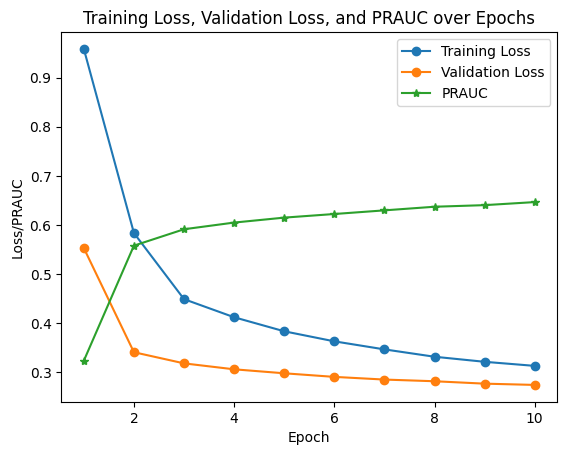

**- Training with symptoms**

In [ ]:
from pyhealth.trainer import Trainer

trainer_tr_symptoms = Trainer(model=model_tr_symptoms)
trainer_tr_symptoms.train(
    model_name="transformer",
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    epochs=50,
    optimizer_params = {"lr": 2 * 1e-4},
    monitor="pr_auc_samples",
    monitor_criterion="max",
)

### Results

loss: 0.1799
New best pr_auc_samples score (0.5844) at epoch-40, step-2091

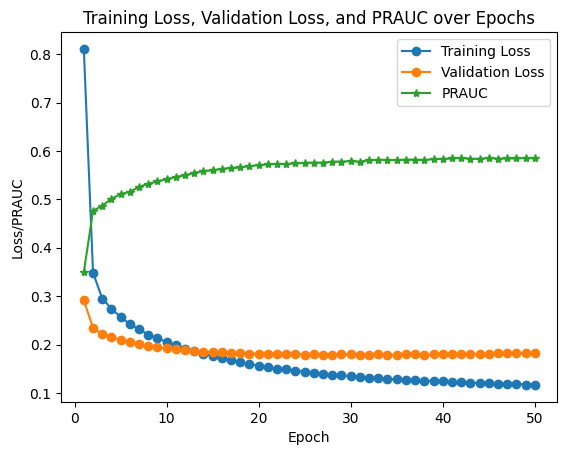

**- Transformer Evaluation**

In [223]:
### Without Symptoms - loss 0.3239 - time: 0m 6s
from pyhealth.metrics import multilabel_metrics_fn

y_true_tr, y_prob_tr, loss_tr = trainer_tr.inference(test_loader)
metrics = ["accuracy", "f1_samples", "pr_auc_samples", "jaccard_samples"]
multilabel_metrics_fn(y_true_tr, y_prob_tr, metrics=metrics)

Evaluation: 100%|██████████| 7/7 [00:00<00:00, 64.07it/s]


{'accuracy': 0.8929554968054637,
 'f1_samples': 0.5066958446595764,
 'pr_auc_samples': 0.6258955924552839,
 'jaccard_samples': 0.34884642635231966}

In [19]:
### With Symptoms - loss 0.3192 - time: 0m 9s
from pyhealth.metrics import multilabel_metrics_fn

y_true_tr_s, y_prob_tr_s, loss_tr_s = trainer_tr_symptoms.inference(test_loader)
metrics = ["accuracy", "f1_samples", "pr_auc_samples", "jaccard_samples"]
multilabel_metrics_fn(y_true_tr_s, y_prob_tr_s, metrics=metrics)

Evaluation: 100%|██████████| 7/7 [00:00<00:00, 76.44it/s]


{'accuracy': 0.9381360806181391,
 'f1_samples': 0.48055933544795987,
 'pr_auc_samples': 0.6114930832175687,
 'jaccard_samples': 0.3284850321801622}

### SafeDrug

**- SafeDrug without symptoms**

In [225]:
from pyhealth.models import SafeDrug

model_safe = SafeDrug(
    dataset=mimic3sample
)

**- SafeDrug with symptoms**

In [226]:
from pyhealth.models import SafeDrug_Mod

model_safe_symptoms = SafeDrug_Mod(
    dataset=mimic3sample
)

**- Training without symptoms**

In [ ]:
from pyhealth.trainer import Trainer

trainer_safe = Trainer(model=model_safe)
trainer_safe.train(
    model_name="safedrug",
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    epochs=10,
    optimizer_params = {"lr": 2 * 1e-4},
    monitor="pr_auc_samples",
)

loss: 0.2503
New best pr_auc_samples score (0.6564) at epoch-8, step-459

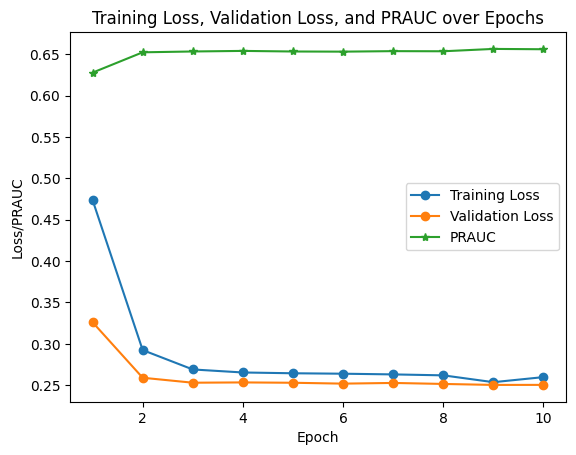

**- Training with symptoms**

In [ ]:
from pyhealth.trainer import Trainer

trainer_safe_symptoms = Trainer(model=model_safe_symptoms)
trainer_safe_symptoms.train(
    model_name="safedrug",
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    epochs=10,
    optimizer_params = {"lr": 2 * 1e-4},
    monitor="pr_auc_samples",
)

loss: 0.2523
New best pr_auc_samples score (0.6550) at epoch-6, step-357

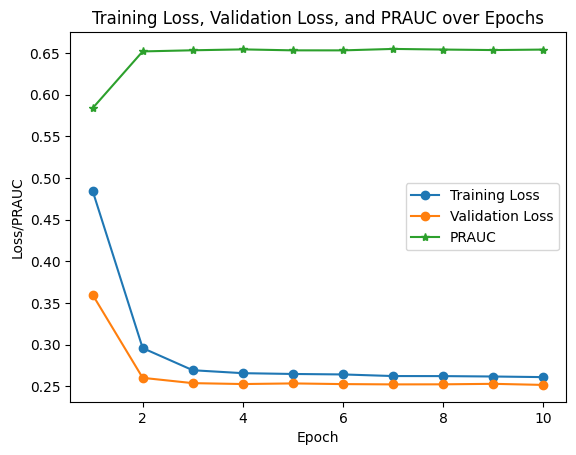

**- SafeDrug Evaluation**

In [229]:
### Without Symptoms - loss 0.2672 - time: 2m 6s
from pyhealth.metrics import multilabel_metrics_fn

y_true_safe, y_prob_safe, loss_safe = trainer_safe.inference(test_loader)
metrics = ["accuracy", "f1_samples", "pr_auc_samples", "jaccard_samples"]
multilabel_metrics_fn(y_true_safe, y_prob_safe, metrics=metrics)

Evaluation: 100%|██████████| 7/7 [00:02<00:00,  2.46it/s]


{'accuracy': 0.8926801057501652,
 'f1_samples': 0.46661275056800083,
 'pr_auc_samples': 0.6270758763872015,
 'jaccard_samples': 0.31076166173689124}

In [230]:
### With Symptoms - loss 0.2666 - time: 2m 0s
from pyhealth.metrics import multilabel_metrics_fn

y_true_safe_s, y_prob_safe_s, loss_safe_s = trainer_safe_symptoms.inference(test_loader)
metrics = ["accuracy", "f1_samples", "pr_auc_samples", "jaccard_samples"]
multilabel_metrics_fn(y_true_safe_s, y_prob_safe_s, metrics=metrics)

Evaluation: 100%|██████████| 7/7 [00:02<00:00,  2.93it/s]


{'accuracy': 0.8925148711169861,
 'f1_samples': 0.47263706593544114,
 'pr_auc_samples': 0.6248807689518094,
 'jaccard_samples': 0.3164571303390051}

### GAMENet

### GRASP

### RETAIN

### GRAM

### KAME

### MoleRec

### RNN

**- RNN without symptoms**

In [241]:
from pyhealth.models import RNN

model_rnn = RNN(
    dataset=mimic3sample,
    feature_keys=["conditions", "procedures"],
    label_key="drugs",
    mode="multilabel",
)

**- Training without symptoms**

In [ ]:
from pyhealth.trainer import Trainer

trainer_rnn = Trainer(model=model_rnn)
trainer_rnn.train(
    model_name="rnn",
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    epochs=10,
    optimizer_params = {"lr": 2 * 1e-4},
    monitor="pr_auc_samples",
)

loss: 0.2564
New best pr_auc_samples score (0.6729) at epoch-9, step-510

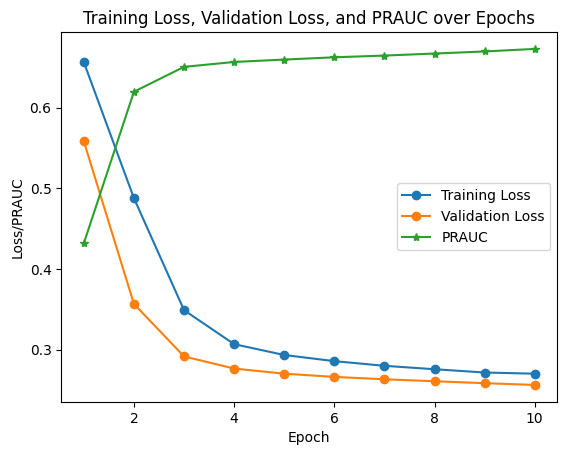

**- RNN Evaluation**

In [243]:
### Without Symptoms - loss 0.3239 - time: 0m 6s
from pyhealth.metrics import multilabel_metrics_fn

y_true_rnn, y_prob_rnn, loss_rnn = trainer_rnn.inference(test_loader)
metrics = ["accuracy", "f1_samples", "pr_auc_samples", "jaccard_samples"]
multilabel_metrics_fn(y_true_rnn, y_prob_rnn, metrics=metrics)

Evaluation: 100%|██████████| 7/7 [00:00<00:00, 136.85it/s]


{'accuracy': 0.8959572593082177,
 'f1_samples': 0.5208913438646415,
 'pr_auc_samples': 0.6492154854289413,
 'jaccard_samples': 0.361292772853502}

## Let'see some recommendation...

In [ ]:
import numpy as np
import pandas as pd
from pyhealth.medcode import InnerMap

# initialize an InnerMap
atc = InnerMap.load("ATC")

sorted_indices = []
for i in range(len(y_prob)):
    top_indices = np.argsort(y_prob[i, :])[::-1][:10]
    sorted_values = y_prob[i, top_indices]
    sorted_indices.append(top_indices)

patient_ids = []
visit_ids = []
rec_drug = []

# get the list of all drugs in the dataset
list_drugs = mimic3sample.get_all_tokens('drugs')

# iterate over the top indexes for each sample in test_ds
for sample, top in zip(test_ds, sorted_indices):
   
    # append the patient id and visit id to their respective lists
    patient_ids.append(sample['patient_id'])
    visit_ids.append(sample['visit_id'])
   
    # create an empty list to store the recommended drugs for this sample
    sample_rec_drug = []
   
    # iterate over the top indexes for this sample
    for i in top:
       
        # append the drug at the i-th index to the recommended drugs list for this sample
        sample_rec_drug.append(list_drugs[i])
   
    # append the recommended drugs for this sample to the recommended drugs list
    rec_drug.append(sample_rec_drug)

# create a dataframe with the patient ids, visit ids, and recommended drugs
df_rec_drug = pd.DataFrame({'patient_id': patient_ids, 'visit_id': visit_ids, 'rec_drug': rec_drug})
df_rec_drug

In [125]:
from pyhealth.medcode import InnerMap

# initialize an InnerMap
atc = InnerMap.load("ATC")

# select a patient from df_rec_drug
patient_id = 10884
visit_id = 150905
patient_df = df_rec_drug[df_rec_drug['patient_id'].astype(int)==patient_id]
patient_df = patient_df[patient_df['visit_id'].astype(int)==visit_id]

# iterate over the recommended drugs for the selected patient
for drugs in patient_df['rec_drug']:
    # lookup the ATC code for each drug and print it
    for drug in drugs:
        print(f"{drug}: {atc.lookup(drug)}")

B05XA: Electrolyte solutions
N03AX: Other antiepileptics in ATC
M04AC: Preparations with no effect on uric acid metabolism
M03BA: Carbamic acid esters, centrally acting muscle relaxants
G04CA: Alpha-adrenoreceptor antagonists, benign prostatic hypertrophy
J01EE: Combinations of sulfonamides and trimethoprim, incl. derivatives
N02BE: Anilide analgesics and antipyretics
B01AB: Heparin group antithrombotic drugs
N05CF: Benzodiazepine related hypnotics and sedatives
A02BC: Proton pump inhibitors for peptic ulcer and GORD


In [124]:
from pyhealth.medcode import InnerMap

# select a patient from df_rec_drug
patient_id = 10884
visit_id = 150905

for sample in test_ds:
    if (sample['patient_id'] == str(patient_id)) and (sample['visit_id'] == str(visit_id)):
        conditions = sample['conditions']
        procedures = sample['procedures']
        symptoms = sample['symptoms']

# initialize an InnerMap
icd9cm = InnerMap.load("ICD9CM")
i=0
for condition in conditions:
    for code in condition:
        print(f"Condition {i}: {icd9cm.lookup(code)}")
        i+=1

# initialize an InnerMap
icd9pr = InnerMap.load("ICD9PROC")
i=0
for procedure in procedures:
    for code in procedure:
        print(f"Procedure {i}: {icd9pr.lookup(code)}")
        i+=1

i=0
for symptom in symptoms:
    for code in symptom:
        print(f"Symptom {i}: {icd9cm.lookup(code)}")
        i+=1

Condition 0: Acute and subacute necrosis of liver
Condition 1: Alcoholic cirrhosis of liver
Condition 2: Hepatorenal syndrome
Condition 3: Acute kidney failure with lesion of tubular necrosis
Condition 4: Congestive heart failure, unspecified
Condition 5: Hyposmolality and/or hyponatremia
Condition 6: Chronic kidney disease, unspecified
Condition 7: Toxic encephalopathy
Condition 8: Hepatic encephalopathy
Condition 9: Calculus of gallbladder with other cholecystitis, without mention of obstruction
Condition 10: Ascites
Condition 11: Acquired coagulation factor deficiency
Condition 12: Thrombocytopenia, unspecified
Condition 13: Unspecified essential hypertension
Condition 14: Other specified disorders of pancreatic internal secretion
Condition 15: Adrenal cortical steroids causing adverse effects in therapeutic use
Condition 16: Acute alcoholic intoxication in alcoholism, in remission
Condition 17: Esophageal reflux
Condition 18: Personal history of urinary calculi
Condition 19: Aphasi